<a href="https://colab.research.google.com/github/Kenz2000/Projet-DATA2/blob/Amir/Partie2(classic3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importations des librairies**


In [1]:
%%capture
! pip install umap-learn
! gdown 'https://drive.google.com/uc?id=1zTDcgnFtQWUeXgIce4O2Z2OPn0vJH1aD'
! pip install transformers

In [2]:
from gensim.models import KeyedVectors
import numpy as np
import h5py as h5
import re
import pandas as pd
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings
from umap import UMAP
from utils_py import accuracy
from wordcloud import WordCloud, STOPWORDS

/content/utils_py.py:167: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(sys.argv) is not 3:


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Algorithme de clustering**

In [4]:
import os
import math
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.cluster import KMeans
from tqdm import tqdm

In [5]:
TF_FLOAT_TYPE = tf.float32

tf.disable_eager_execution()

def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)
    return input

def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)

    # Encoder
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    # Decoder
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])

    return embedding, output

def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def next_batch(num, data):
    """
    Return a total of `num` random samples.
    """
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])

    return indices, batch_data

# **Deep Clustering Network**

In [6]:
class DcnCompGraph(object):
    """Computation graph for the Deep Clustering Network model proposed in:
        Yang, B., Fu, X., Sidiropoulos, N. D., & Hong, M. (2017). Towards K-means-friendly Spaces: Simultaneous Deep
        Learning and Clustering. In ICML '17 (pp. 3861–3870).
    This implementation is inspired by https://github.com/boyangumn/DCN
    """

    def __init__(self, ae_specs, n_clusters, batch_size, n_samples, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0]) - 1) / 2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(batch_size, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g
        self.ae_loss = tf.reduce_mean(rec_error)

        # Clustering loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## Clustering assignments for all samples in the dataset
        initial_clustering_assign = tf.random_uniform(minval=0, maxval=n_clusters, dtype=tf.int32, shape=[n_samples])
        self.cluster_assign = tf.Variable(initial_clustering_assign, name='cluster_assign', dtype=tf.int32, trainable=False)

        ## Get the cluster representative corresponding to the cluster of each batch sample
        self.indices = tf.placeholder(dtype=tf.int32, shape=batch_size)  # Placeholder for sample indices in current batch
        batch_clust_rep = []
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            batch_clust_rep.append(self.cluster_rep[k, :])
        stack_batch_clust_rep = tf.stack(batch_clust_rep)

        ## Compute the k-means term
        clustering_error = f_func(self.embedding, stack_batch_clust_rep)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(clustering_error)
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DCN
        self.train_op = optimizer.minimize(self.loss)

        # As it has been pointed out in the DCN paper, first the weights of the autoencoder shall be trained then the
        # assignments and cluster representatives. So far in the computation graph we have optimized the weights of the
        # autoencoder, now it's the time for the assignments and representatives.

        # Update the clustering assignments
        for j in range(batch_size):
            # Find which cluster representative is the closest to the current batch sample
            new_assign = tf.argmin(f_func(tf.reshape(self.embedding[j, :], (1, embedding_size)), self.cluster_rep),
                                   output_type=tf.int32)
            # Update the clustering assignment
            self.cluster_assign_update = tf.assign(self.cluster_assign[self.indices[j]], new_assign)

        # Update the cluster representatives
        ## Initialize the value of count
        initial_count = tf.constant(100.0, shape=[n_clusters])
        count = tf.Variable(initial_count, name='count', dtype=TF_FLOAT_TYPE, trainable=False)
        ## Update the cluster representatives according to Equation (8) in the DCN paper
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            self.count_update = tf.assign(count[k], count[k] + 1)  # Updated count for cluster assignments
            new_rep = self.cluster_rep[k] - (1 / count[k]) * (self.cluster_rep[k] - self.embedding[j])
            self.cluster_rep_update = tf.assign(self.cluster_rep[k], new_rep)

In [7]:
def DCN(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=50, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)

    cg = DcnCompGraph([dimensions, activations, names], n_clusters, batch_size, n_samples,
                      lambda_)

    # Run the computation graph
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):

                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices_, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                       feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices_)):
                        embeddings[indices_[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DCN
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

            # The clustering assignments are used to initialize the clustering assignments in DCN
            sess.run(tf.assign(cg.cluster_assign, kmeans_model.labels_))

        # Train the full DCN model
        print("Starting DCN training...")
        ## Loop over epochs
        for epoch in tqdm(range(n_finetuning_epochs)):
            # print("Training step: epoch {}".format(epoch))

            # Loop over the samples
            for _ in range(n_batches):
                # Fetch a random data batch of the specified size
                indices_, data_batch = next_batch(batch_size, data)

                # Run the computation graph on the data batch
                _, _, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                    sess.run((cg.train_op, cg.cluster_assign_update, cg.count_update, cg.cluster_rep_update, cg.loss,
                              cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                             feed_dict={cg.input: data_batch, cg.indices: indices_})
        
        embeddings = np.zeros((n_samples, embedding_size), dtype=float)
        for _ in range(n_batches):
            # Fetch a random data batch of the specified size
            indices_, data_batch = next_batch(batch_size, data)

            # Run the computation graph on the data batch
            _, _, embeddings_, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                sess.run((cg.train_op, cg.cluster_assign_update, cg.embedding, cg.count_update, cg.cluster_rep_update, cg.loss,
                          cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                          feed_dict={cg.input: data_batch, cg.indices: indices_})

            for j in range(len(indices_)):
                embeddings[indices_[j], :] = embeddings_[j, :]
                
    return embeddings, cluster_assign_

**Deep K-means**

In [8]:
class DkmCompGraph(object):
    """Computation graph for Deep K-Means
    """

    def __init__(self, ae_specs, n_clusters, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0])-1)/2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(None, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g

        # k-Means loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## First, compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, n_clusters):
            dist = f_func(self.embedding, tf.reshape(self.cluster_rep[i, :], (1, embedding_size)))
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        ## Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(list_dist, axis=0)

        ## Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        self.alpha = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=())  # Placeholder tensor for alpha
        list_exp = []
        for i in range(n_clusters):
            exp = tf.exp(-self.alpha * (self.stack_dist[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)

        ## Fourth, compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = self.stack_dist[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(tf.reduce_sum(stack_weighted_dist, axis=0))
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DKM
        self.train_op = optimizer.minimize(self.loss) # Train the whole DKM model

In [9]:
def DKM(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    """
        The final number of finetuning epochs is n_finetuning_epochs * 20 if pretrain and n_finetuning_epochs * 40 if annealing
    """
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained
    annealing = False # Specify if annealing should be used

    # Define the alpha scheme depending on if the approach includes annealing/pretraining
    if annealing and not pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = 0.1
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif not annealing and pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider (constant values are used here)
        alphas = 1000*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    else:
        raise Exception("Run with either annealing (-a) or pretraining (-p), but not both.")

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    config = tf.ConfigProto(gpu_options=gpu_options)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
      
    # Define the computation graph for DKM
    cg = DkmCompGraph([dimensions, activations, names], n_clusters, lambda_)

    # Run the computation graph
    with tf.Session(config=config) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Variables to save tensor content
        distances = np.zeros((n_clusters, n_samples))

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                        feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices)):
                        embeddings[indices[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DKM
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

        # Train the full DKM model
        if (len(alphas) > 0):
            print("Starting DKM training...")
        ## Loop over alpha (inverse temperature), from small to large values
        for k in tqdm(range(len(alphas))):
            # Loop over epochs per alpha
            for _ in range(n_finetuning_epochs):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph on the data batch
                    _, loss_, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
                        sess.run((cg.train_op, cg.loss, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                                  feed_dict={cg.input: data_batch, cg.alpha: alphas[k]})

                    # Save the distances for batch samples
                    for j in range(len(indices)):
                        distances[:, indices[j]] = stack_dist_[:, j]

        _, loss_, X_reduced, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
        sess.run((cg.train_op, cg.loss, cg.embedding, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                  feed_dict={cg.input: data, cg.alpha: alphas[k]})

        distances = stack_dist_

        # Infer cluster assignments for all samples
        cluster_assign = np.zeros((n_samples), dtype=float)
        for i in range(n_samples):
            index_closest_cluster = np.argmin(distances[:, i])
            cluster_assign[i] = index_closest_cluster
        cluster_assign = cluster_assign.astype(np.int64)

    return X_reduced, cluster_assign

**Chargement des données**

In [10]:
df = pd.read_csv("./classic3.csv")
texts = df['text'].values
classic3_labels = df["label"].values
k_classic3 = len(df['label'].unique())

In [16]:
classic3_word2vec= pd.read_hdf("/content/drive/MyDrive/Data2/classic3_word2vec.h5").to_numpy()
classic3_glove= pd.read_hdf("/content/drive/MyDrive/Data2/classic3_glove.h5").to_numpy()

**Fonctions Utilisées**

In [17]:
def map_labels(labels):
    mapping = {}
    for (i,name) in enumerate(set(labels)):
        mapping[name] = i
    return [mapping[letter] for letter in labels]

In [19]:
def eval_clustering_2D(x, labels, pred_labels, methods):
    fig, axes = plt.subplots(1, len(pred_labels)+1, figsize=(20,10))
    axes[0].scatter(x[:,0], x[:,1],
                    c=labels, edgecolor='none', alpha=1,)
    axes[0].title.set_text('Real Labels')
    nmis, aris, accs = {}, {}, {}
    for i in range(len(pred_labels)):
        nmi = normalized_mutual_info_score(labels, pred_labels[i])
        ari = adjusted_rand_score(labels, pred_labels[i])
        acc = accuracy(labels, pred_labels[i])
        nmis[methods[i]] = nmi
        aris[methods[i]] = ari
        accs[methods[i]] = acc
        axes[i+1].scatter(x[:,0], x[:,1],
                    c=pred_labels[i], edgecolor='none', alpha=1,)
        axes[i+1].title.set_text('{}\nNMI = {:.6f}\nARI={:.6f}\nACC={:.6f}'.format(methods[i], nmi, ari, acc))
    
    return nmis, aris, accs

In [20]:
def run_methods(func, X, k, method_name, file_name, dataset, rep, ns = [2, 3, 5, 10, 20]):
  print(f'Executing of {method_name} method on the dataset: "{dataset}" with {rep} representation.')
  ALG_labels, ALG_methods = [], []
  for n_components in ns:
    print('Number of components:', n_components)
    alg_embeddings, alg_labels = func(X, k, n_components, seed=n_components)
    ALG_labels.append(alg_labels), ALG_methods.append(f'{method_name} - n_components = {n_components}')
    with h5.File(file_name, 'a') as alg_file:
      alg_file.create_dataset(f'{dataset}_default{n_components}components_embed_{rep}', data=alg_embeddings)
      alg_file.create_dataset(f'{dataset}_default{n_components}components_labels_{rep}', data=alg_labels)
  return ALG_labels, ALG_methods

In [21]:
def print_wordcloud(X, labels):
    temp_df = pd.DataFrame({
        "text": X,
        "labels": labels
    })
    for label in temp_df['labels'].unique():
        alltext = ' '.join(temp_df[temp_df['labels']== label]['text'])
        wordcloud = WordCloud().generate(alltext)
        # Display the generated image:
        print(f'Class: {label}')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        print(f'\n')

# **Approche jointe,simultanée**

**La représentation Word2Vec**

In [35]:
X = classic3_word2vec
rep = 'word2vec'
dataset = 'classic3'
k = k_classic3
labels = classic3_labels
classic3_resluts = {}

### DCN (Deep Clustering network)

In [ ]:
file_name = './dcn_file1.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic3" with word2vec representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:18<00:00,  1.57s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Number of components: 3


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:20<00:00,  1.62s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


Number of components: 5


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:18<00:00,  1.57s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:27<00:00,  1.76s/it]


Number of components: 10


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:27<00:00,  1.75s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


Number of components: 20


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:21<00:00,  1.64s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


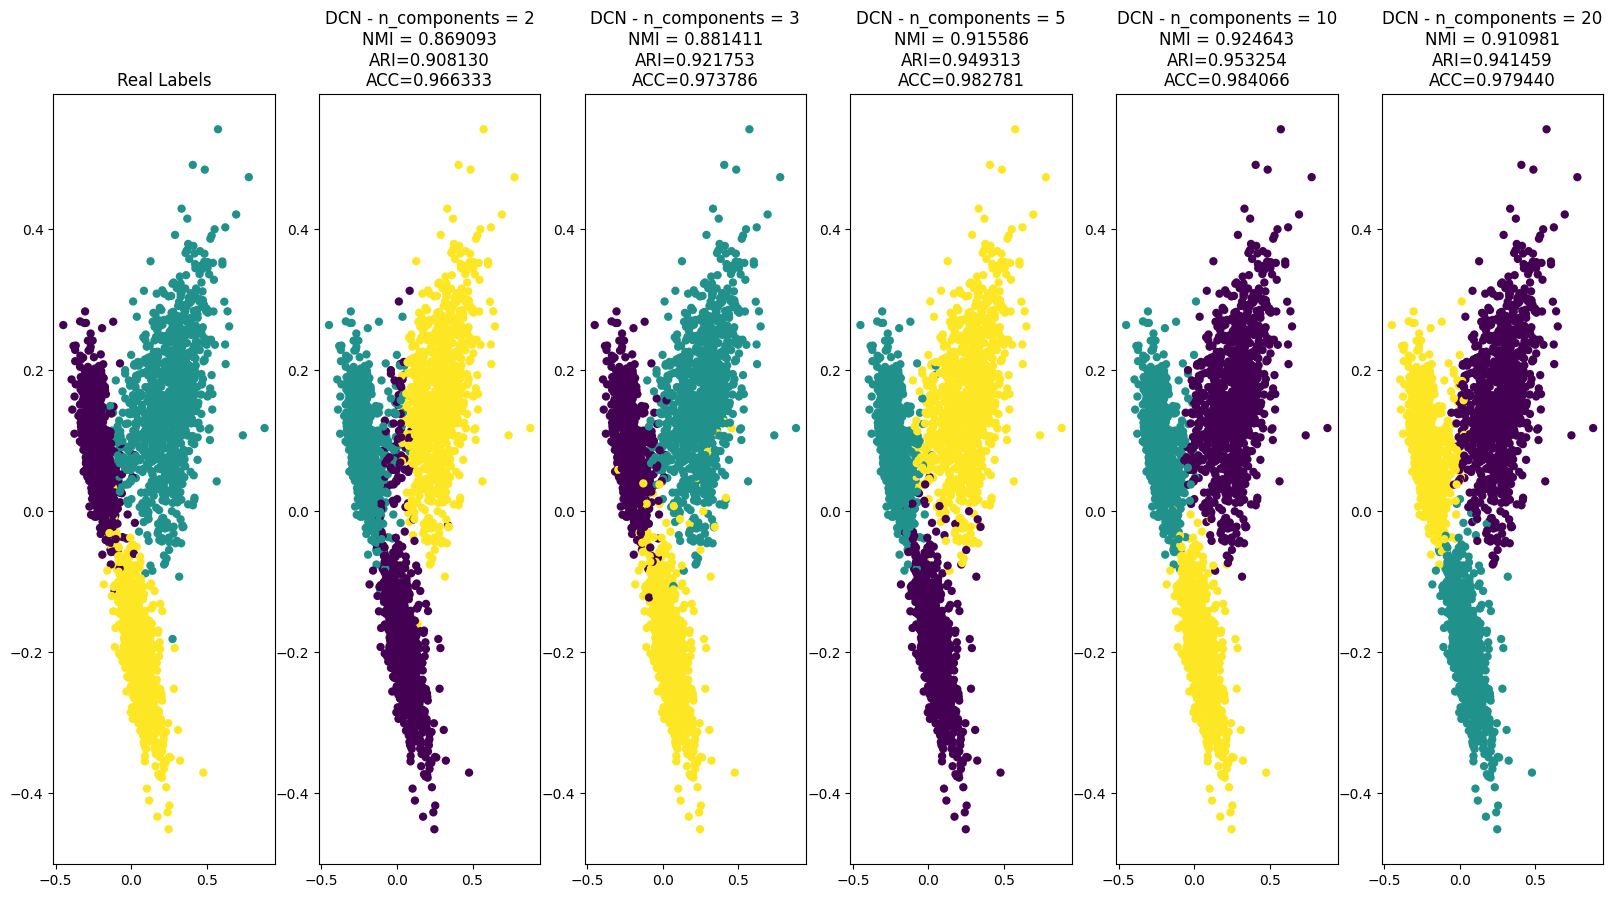

In [36]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)


Lors de l'analyse des scores et des visualisations obtenus en utilisant l'application de DCN sur la représentation Word2vec de Classic3 avec diverses dimensions, il est remarquable que les résultats sont significatifs. En effet, le taux d'accuracy dépasse les 96 %, le NMI dépasse les 87 et l'ARI dépasse les 90 %. De plus, les clusters formés se distinguent clairement et sont homogènes pour toutes les combinaisons de DCN.

In [38]:
key = '{}_{}_dcn'.format(dataset, rep)
classic3_resluts[key] = (nmis, aris, accs)

### DKM (Deep K_means)

In [ ]:
file_name = './dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "classic3" with word2vec representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:23<00:00,  1.67s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [02:37<00:00,  7.87s/it]


Number of components: 3


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:18<00:00,  1.57s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [02:40<00:00,  8.01s/it]


Number of components: 5


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:18<00:00,  1.57s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [02:40<00:00,  8.01s/it]


Number of components: 10


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:19<00:00,  1.59s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [02:42<00:00,  8.10s/it]


Number of components: 20


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:19<00:00,  1.60s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [02:40<00:00,  8.01s/it]


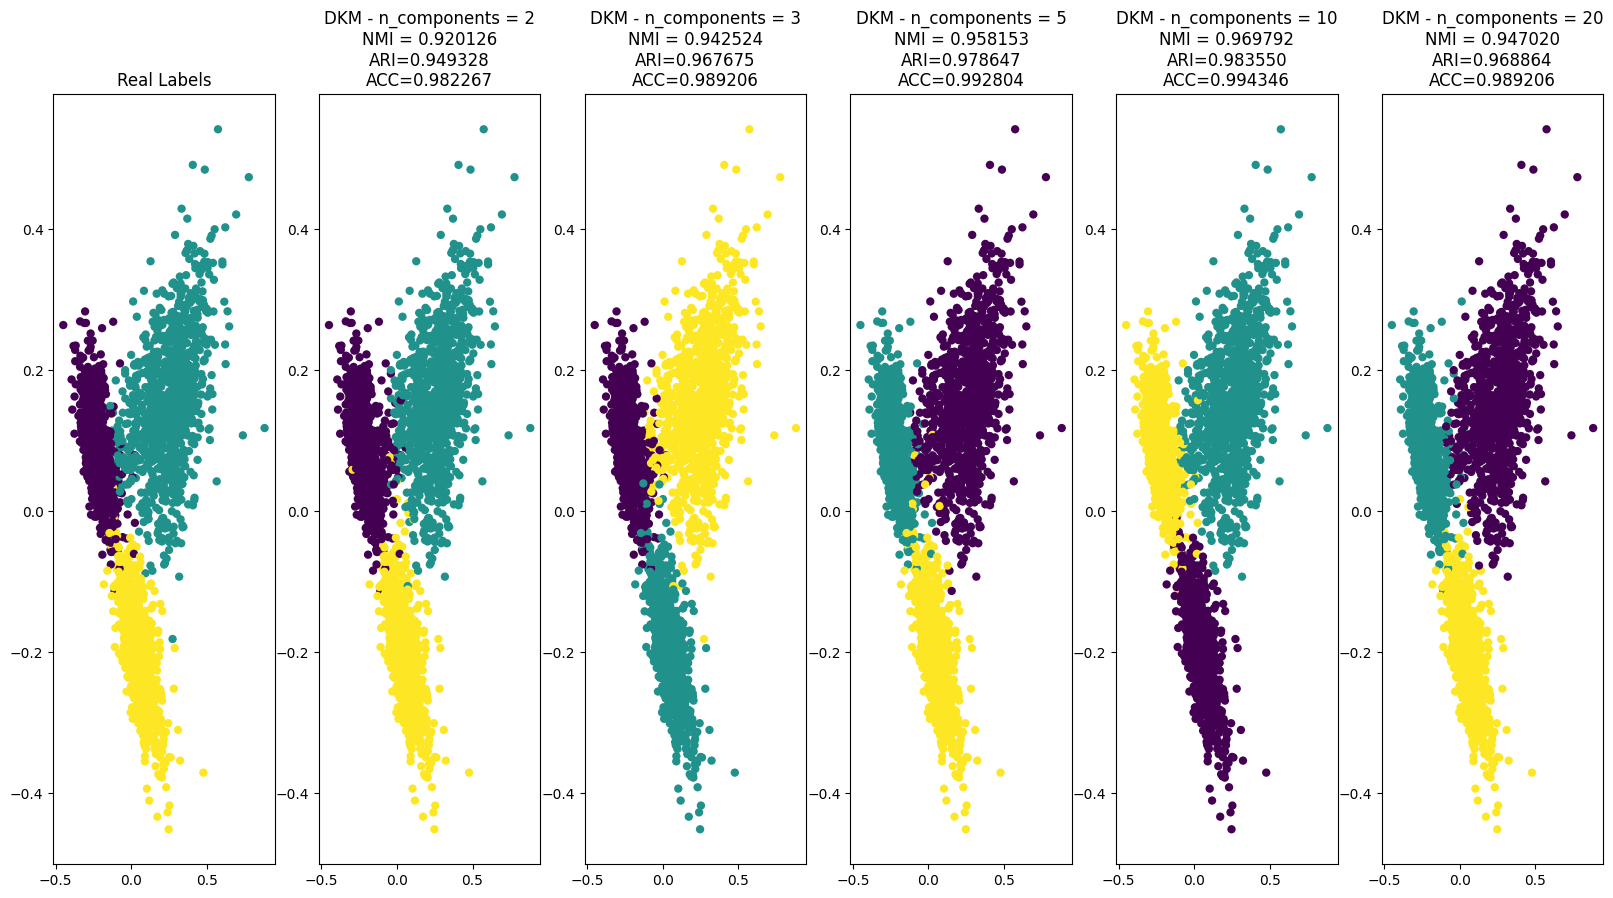

In [39]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

Lorsque nous utilisons la même représentation Word2vec et appliquons la méthode DKM avec différentes dimensions, nous constatons que la méthode utilisant 10 composantes présente la meilleure performance en matière de scores par rapport aux résultats obtenus avec DCN. En effet, elle affiche un taux d'accuracy de 99 %, un NMI de 95 % et un ARI de 97 %.

Il est à noter que tous les résultats montrent de manière claire une bonne séparation et homogénéité des clusters.


In [40]:
key = '{}_{}_dkm'.format(dataset, rep)
classic3_resluts[key] = (nmis, aris, accs)

## La représentation  GloVe

In [66]:
X = classic3_glove
rep = 'GloVe'
dataset = 'classic3'

###  DCN

In [68]:
file_name = './dcn_file1.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic3" with GloVe representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:35<00:00,  1.91s/it]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:45<00:00,  2.11s/it]


Number of components: 3


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:37<00:00,  1.95s/it]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:48<00:00,  2.17s/it]


Number of components: 5


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:34<00:00,  1.89s/it]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:45<00:00,  2.11s/it]


Number of components: 10


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:37<00:00,  1.95s/it]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:45<00:00,  2.11s/it]


Number of components: 20


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:35<00:00,  1.92s/it]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:45<00:00,  2.11s/it]


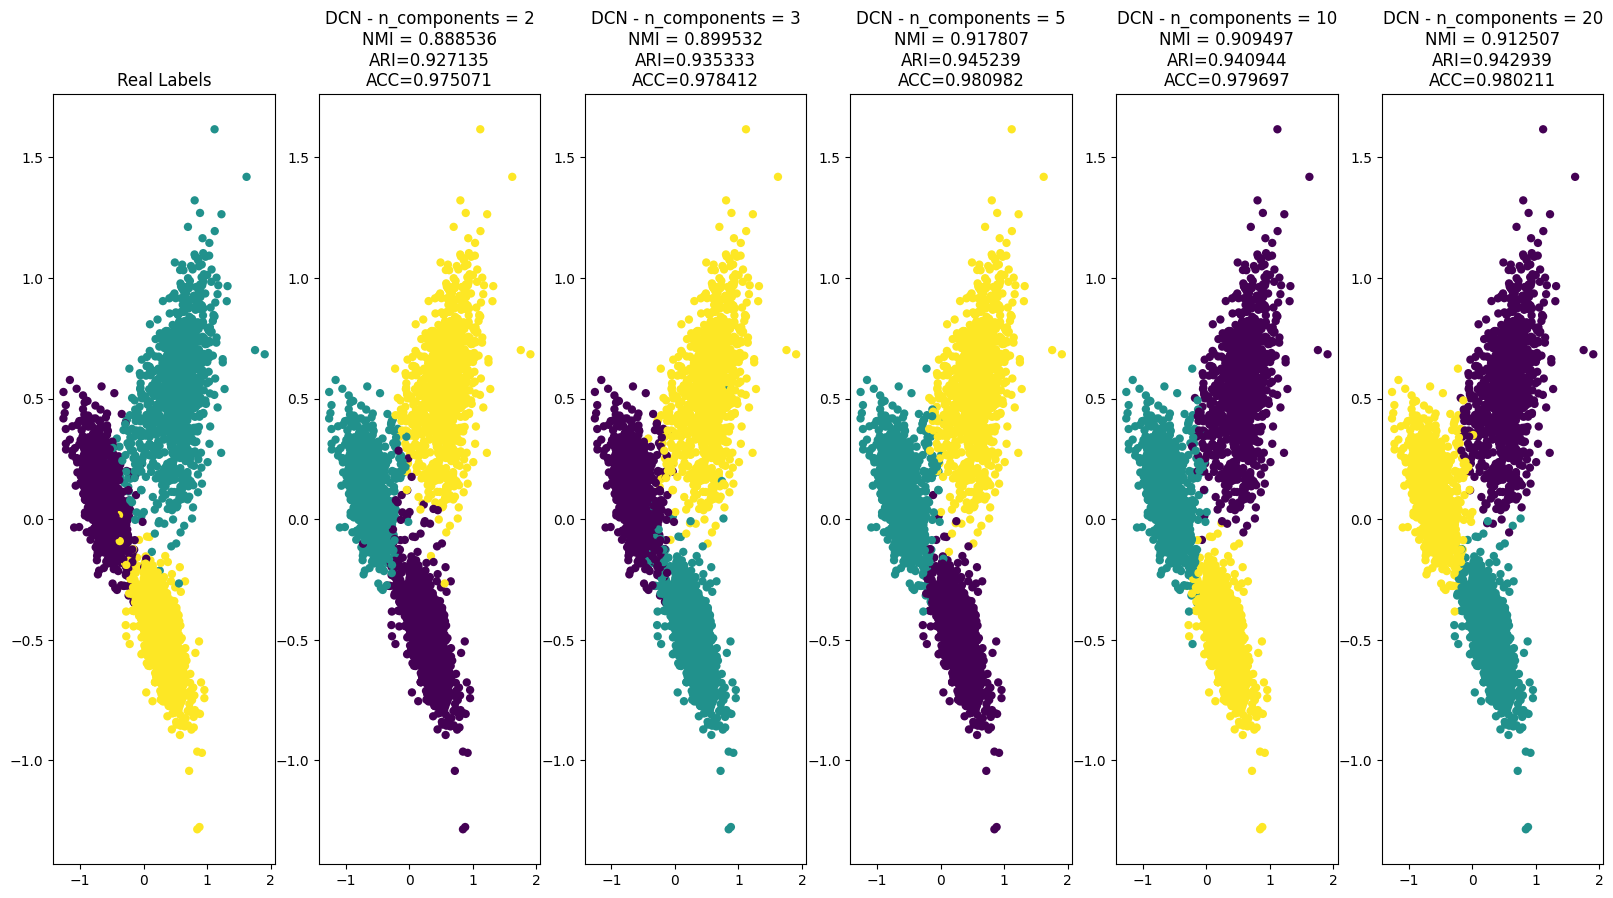

In [70]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Après avoir appliqué la DCN (en variant le nombre de composantes) sur la représentation Glove du dataset classic 3, il est remarquable que tous les résultats sont bons, avec un taux d'accuracy dépassant 97%, un NMI dépassant 88% et un ARI dépassant 92%. De plus, nous observons une séparation et une homogénéité des clusters formés.

Il est à noter que la méthode DCN avec un nombre de composantes égal à 5 se distingue comme la meilleure en termes de scores.


In [71]:

key = '{}_{}_dcn'.format(dataset, rep)
classic3_resluts[key] = (nmis, aris, accs)

**DKM (Deep Kmeans)**

In [73]:
file_name = './dkm_file1.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "classic3" with GloVe representation.
Number of components: 2


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:36<00:00,  1.93s/it]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [03:12<00:00,  9.61s/it]


Number of components: 3


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:33<00:00,  1.87s/it]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [03:06<00:00,  9.33s/it]


Number of components: 5


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:34<00:00,  1.90s/it]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [03:07<00:00,  9.37s/it]


Number of components: 10


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:37<00:00,  1.95s/it]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [03:23<00:00, 10.17s/it]


Number of components: 20


<ipython-input-5-d8c36472c57e>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:38<00:00,  1.97s/it]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [03:23<00:00, 10.19s/it]


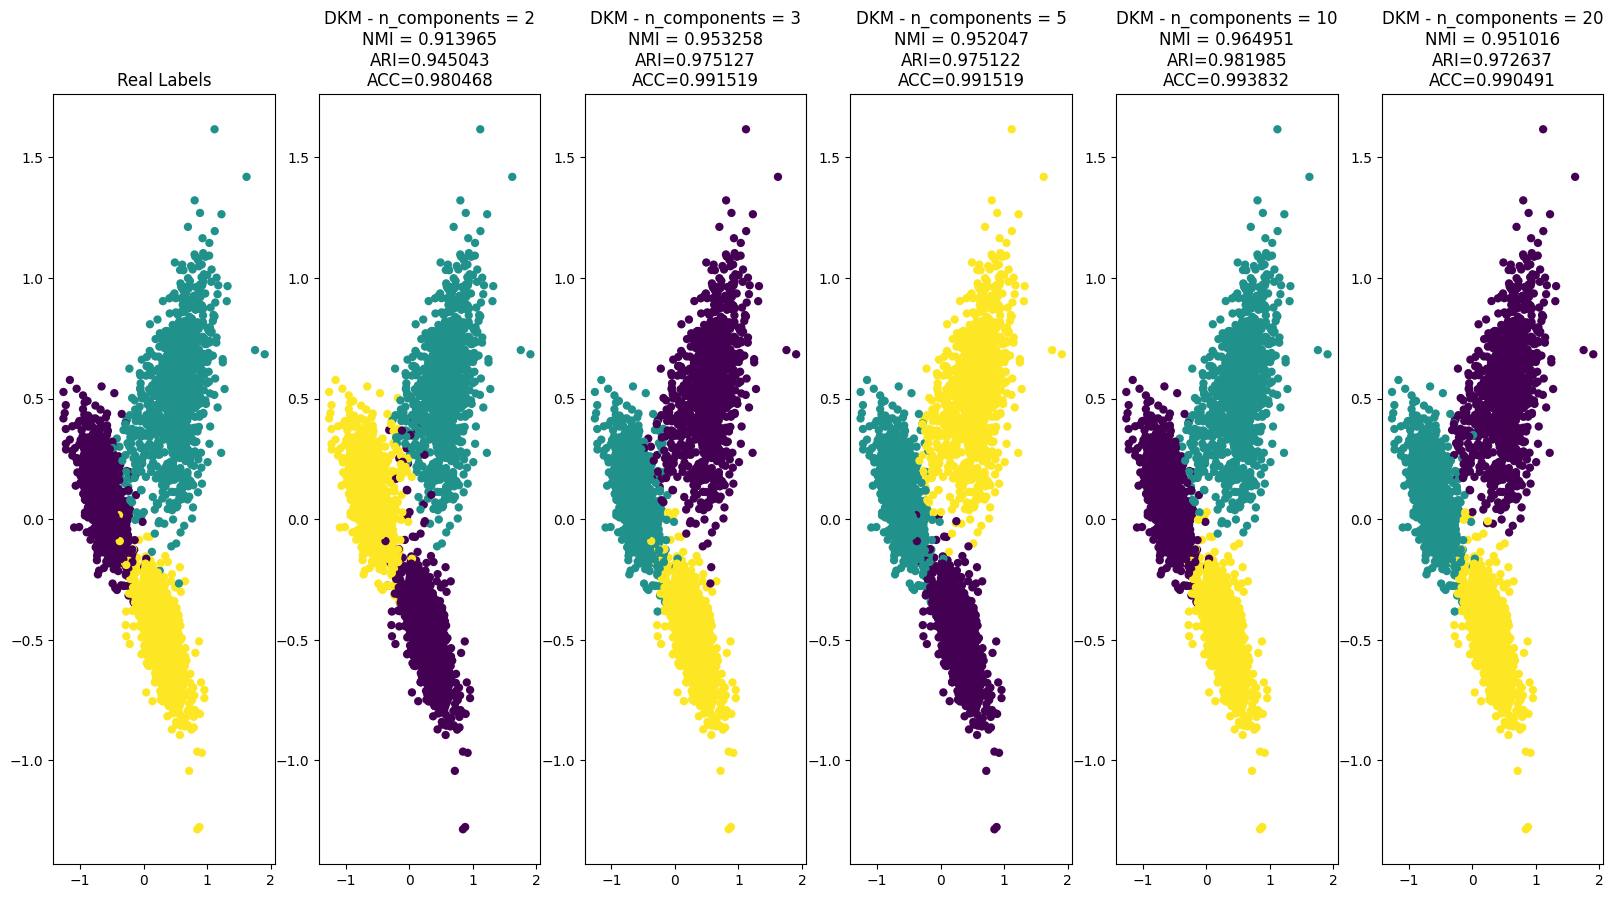

In [74]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

Lorsque nous utilisons la même représentation Glove et appliquons cette fois-ci la méthode DKM avec différentes dimensions, nous observons que la méthode utilisant 5 composantes (dimensions) présente les meilleurs résultats en termes de scores par rapport aux résultats obtenus avec DCN. En effet, elle a donné un taux d'accuracy de 99 %, un NMI de 95 % et un ARI de 97 %.

Il est à noter que tous les résultats démontrent de manière très claire une séparation satisfaisante et une homogénéité des clusters.


In [75]:
key = '{}_{}_dkm'.format(dataset, rep)
classic3_resluts[key] = (nmis, aris, accs)

**Tableau récapitulatifn des résultats**

In [76]:
with open("./classic3part2results.pkl", "wb") as results_file:
  pickle.dump(classic3_resluts, results_file)

In [77]:
CLASSIC3_results = {key: {inkey: {'nmi': nmi[inkey],'ari': ari[inkey],'acc': acc[inkey]} for inkey in nmi.keys()}  for key, (nmi, ari, acc) in classic3_resluts.items()}
classic3_results_dataframe = pd.DataFrame.from_dict({(i,j): CLASSIC3_results[i][j] 
                           for i in CLASSIC3_results.keys() 
                           for j in CLASSIC3_results[i].keys()},
                       orient='index')
classic3_results_dataframe

nmi       ari       acc
classic3_word2vec_dcn DCN - n_components = 2   0.869093  0.908130  0.966333
                      DCN - n_components = 3   0.881411  0.921753  0.973786
                      DCN - n_components = 5   0.915586  0.949313  0.982781
                      DCN - n_components = 10  0.924643  0.953254  0.984066
                      DCN - n_components = 20  0.910981  0.941459  0.979440
classic3_word2vec_dkm DKM - n_components = 2   0.920126  0.949328  0.982267
                      DKM - n_components = 3   0.942524  0.967675  0.989206
                      DKM - n_components = 5   0.958153  0.978647  0.992804
                      DKM - n_components = 10  0.969792  0.983550  0.994346
                      DKM - n_components = 20  0.947020  0.968864  0.989206
classic3_GloVe_dcn    DCN - n_components = 2   0.888536  0.927135  0.975071
                      DCN - n_components = 3   0.899532  0.935333  0.978412
                      DCN - n_components = 5   0.917807  0.945239  0.980982
                      DCN - n_components = 10  0.909497  0.940944  0.979697
                      DCN - n_components = 20  0.912507  0.942939  0.980211
classic3_GloVe_dkm    DKM - n_components = 2   0.913965  0.945043  0.980468
                      DKM - n_components = 3   0.953258  0.975127  0.991519
                      DKM - n_components = 5   0.952047  0.975122  0.991519
                      DKM - n_components = 10  0.964951  0.981985  0.993832
                      DKM - n_components = 20  0.951016  0.972637  0.990491

In [78]:
metric = "nmi"
classic3_results_dataframe[classic3_results_dataframe[metric] == classic3_results_dataframe[metric].max()]

,,nmi,ari,acc
classic3_word2vec_dkm,DKM - n_components = 10,0.969792,0.98355,0.994346


In [79]:
metric = "ari"
classic3_results_dataframe[classic3_results_dataframe[metric] == classic3_results_dataframe[metric].max()]

,,nmi,ari,acc
classic3_word2vec_dkm,DKM - n_components = 10,0.969792,0.98355,0.994346


In [80]:
metric = "acc"
classic3_results_dataframe[classic3_results_dataframe[metric] == classic3_results_dataframe[metric].max()]

,,nmi,ari,acc
classic3_word2vec_dkm,DKM - n_components = 10,0.969792,0.98355,0.994346


Après une analyse approfondie des résultats obtenus par les méthodes DCN et DKM, en utilisant différents nombres de composantes principales pour les représentations Word2vec et Glove, il est clairement établi, d'après le tableau récapitulatif, que la méthode DKM a obtenu des scores supérieurs pour les deux représentations (Word2vec, Glove). En particulier, la méthode DKM avec n_components=5 appliquée sur Glove se distingue comme la meilleure en termes de scores obtenus, atteignant une précision de 99,42 %, un NMI de 96,97 % et un ARI de 98,35 %

**Comparaison des résultats de Partie 1 et Partie 2**

Après avoir comparé les résultats de l'approche Tandem et de l'approche Jointe/Simultanée sur les deux représentations (Word2vec, Glove), les observations suivantes ont été faites :

Dans la partie 1, la méthode de clustering CAH utilisant le critère Ward sur l'espace d'origine et l'espace réduit par UMAP à 2 dimensions s'est démarquée en obtenant les meilleurs scores (accuracy=99,53 %, NMI=97,10 % et ARI=98,62 %).


Dans la partie 2, les deux méthodes, Deep K-means et Deep Clustering Network, ont produit des résultats significatifs pour les deux représentations, avec une légère supériorité de la méthode DKM qui a atteint une accuracy de 99,42 %, un NMI de 96,97 % et un ARI de 98,35 %.

En conclusion des deux parties, il est remarqué que l'approche Tandem, combinant UMAP et CAH (Ward), a démontré des performances supérieures à celles obtenues par Deep K-means.



